<a href="https://colab.research.google.com/github/rawanalsh5/Final-Project-Slides-Writeup-Code-/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torch
from pathlib import Path
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime

# Configure to display plots inline
%matplotlib inline
# Make plots larger and higher resolution
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['figure.dpi'] = 100

In [2]:
# Set your data path
data_path = r"C:\Users\GEOSA.DESKTOP-EH8I9NS\Desktop\Project_Master\stroke_segmentation_preprocess\data"
case_id = "sub-strokecase0001"
session_id = "ses-0001"

In [3]:
# Define helper functions
def normalize_image(img_data, percentile_low=1, percentile_high=99):
    """Normalize image for better visualization"""
    if np.all(img_data == 0):
        return img_data  # Return as is if all zeros

    low = np.percentile(img_data, percentile_low)
    high = np.percentile(img_data, percentile_high)

    # Avoid division by zero
    if high == low:
        return np.zeros_like(img_data)

    img_normalized = np.clip((img_data - low) / (high - low), 0, 1)
    return img_normalized

def add_colorbar(im, ax, location='right', size='5%', pad=0.05, label=None):
    """Add a nicer colorbar to the image"""
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(location, size=size, pad=pad)
    cbar = plt.colorbar(im, cax=cax)
    if label:
        cbar.set_label(label)
    return cbar

def apply_mask_overlay(img, mask, alpha=0.5, color=[1, 0, 0]):
    """Apply colored mask overlay on image"""
    if mask is None or np.max(mask) == 0:
        return img

    # Create RGB version of grayscale image
    img_rgb = np.stack([img, img, img], axis=-1)

    # Create RGB version of mask (single color)
    mask_rgb = np.zeros((*mask.shape, 3))
    for i, c in enumerate(color):
        mask_rgb[..., i] = mask * c

    # Blend
    mask_binary = (mask > 0).astype(float)
    blended = img_rgb * (1 - mask_binary[..., np.newaxis] * alpha) + mask_rgb * alpha * mask_binary[..., np.newaxis]
    return np.clip(blended, 0, 1)

In [19]:
import os

print("ملف FLAIR موجود؟", os.path.exists("/content/raw/ISLES-2022/sub-strokecase0001/ses-0001/anat/sub-strokecase0001_ses-0001_FLAIR.nii.gz"))
print("مجلد anat موجود؟", os.path.exists("/content/raw/ISLES-2022/sub-strokecase0001/ses-0001/anat"))
print("ملف DWI موجود؟", os.path.exists("/content/raw/ISLES-2022/sub-strokecase0001/ses-0001/dwi/sub-strokecase0001_ses-0001_dwi.nii.gz"))


ملف FLAIR موجود؟ False
مجلد anat موجود؟ False
ملف DWI موجود؟ False


In [20]:
# Load raw data
def load_raw_data(data_dir, case_id, session_id):
    """Load raw MRI data from BIDS format"""
    raw_dir = os.path.join(data_dir, 'raw', 'ISLES-2022', case_id, session_id)

    # Load FLAIR image
    flair_path = "/content/data/raw/ISLES-2022/sub-strokecase0001/ses-0001/anat/sub-strokecase0001_ses-0001_FLAIR.nii.gz"
    print(f"Looking for FLAIR at: {flair_path}")
    flair_img = nib.load(flair_path)
    flair_data = flair_img.get_fdata()
    print(f"FLAIR shape: {flair_data.shape}")

    # Load DWI image
    dwi_path = "/content/data/raw/ISLES-2022/sub-strokecase0001/ses-0001/dwi/sub-strokecase0001_ses-0001_dwi.nii.gz"
    print(f"Looking for DWI at: {dwi_path}")
    dwi_img = nib.load(dwi_path)
    dwi_data = dwi_img.get_fdata()
    print(f"DWI shape: {dwi_data.shape}")

    # Try to load mask if available
    mask_data = None
    mask_path = os.path.join(data_dir, 'raw', 'ISLES-2022', 'derivatives',
                            case_id, session_id, f'{case_id}_{session_id}_msk.nii.gz')
    print(f"Looking for mask at: {mask_path}")
    if os.path.exists(mask_path):
        mask_img = nib.load(mask_path)
        mask_data = mask_img.get_fdata()
        print(f"Mask shape: {mask_data.shape}")
    else:
        print("Mask file not found.")

    return {
        'flair': flair_data,
        'dwi': dwi_data,
        'mask': mask_data,
        'affine': flair_img.affine,
        'header': flair_img.header
    }

# Load the raw data
raw_data = load_raw_data(data_path, case_id, session_id)

Looking for FLAIR at: /content/data/raw/ISLES-2022/sub-strokecase0001/ses-0001/anat/sub-strokecase0001_ses-0001_FLAIR.nii.gz
FLAIR shape: (281, 352, 352)
Looking for DWI at: /content/data/raw/ISLES-2022/sub-strokecase0001/ses-0001/dwi/sub-strokecase0001_ses-0001_dwi.nii.gz
DWI shape: (112, 112, 73)
Looking for mask at: /content/raw/ISLES-2022/derivatives/sub-strokecase0001/ses-0001/sub-strokecase0001_ses-0001_msk.nii.gz
Mask file not found.


In [22]:
data_path = "/content/data"
case_id = "sub-strokecase0001"


In [23]:
# Load processed data
def load_processed_data(data_dir, case_id):
    """Load processed data from PyTorch file"""
    # Try to find the processed file in train or val directory
    train_path = os.path.join(data_dir, 'processed', 'train', f'{case_id}_processed.pt')
    val_path = os.path.join(data_dir, 'processed', 'val', f'{case_id}_processed.pt')

    print(f"Looking for processed data at: \n- {train_path}\n- {val_path}")

    if os.path.exists(train_path):
        processed_path = train_path
        print(f"Found processed data in train directory")
    elif os.path.exists(val_path):
        processed_path = val_path
        print(f"Found processed data in val directory")
    else:
        raise FileNotFoundError(f"Processed data for {case_id} not found in train or val directories")

    # Load the processed data
    processed_data = torch.load(processed_path)

    # Print information about the processed data
    print(f"Processed data type: {type(processed_data)}")
    if isinstance(processed_data, dict):
        print(f"Processed data keys: {list(processed_data.keys())}")
        for key, value in processed_data.items():
            if isinstance(value, torch.Tensor):
                print(f"  {key}: shape {value.shape}, dtype {value.dtype}")
            else:
                print(f"  {key}: type {type(value)}")
    elif isinstance(processed_data, torch.Tensor):
        print(f"Processed data shape: {processed_data.shape}, dtype: {processed_data.dtype}")

    return processed_data

# Load the processed data
processed_data = load_processed_data(data_path, case_id)

Looking for processed data at: 
- /content/data/processed/train/sub-strokecase0001_processed.pt
- /content/data/processed/val/sub-strokecase0001_processed.pt
Found processed data in train directory
Processed data type: <class 'dict'>
Processed data keys: ['flair', 'flair_sym_diff', 'flair_sym_corr', 'flair_sym_struct', 'mid_plane_idx', 'subject_id']
  flair: shape torch.Size([1, 96, 96, 96]), dtype torch.float32
  flair_sym_diff: shape torch.Size([1, 96, 96, 96]), dtype torch.float32
  flair_sym_corr: shape torch.Size([1, 96, 96, 96]), dtype torch.float32
  flair_sym_struct: shape torch.Size([1, 96, 96, 96]), dtype torch.float32
  mid_plane_idx: type <class 'int'>
  subject_id: type <class 'str'>


<ipython-input-24-2d7779cfdf59>:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 0.95])


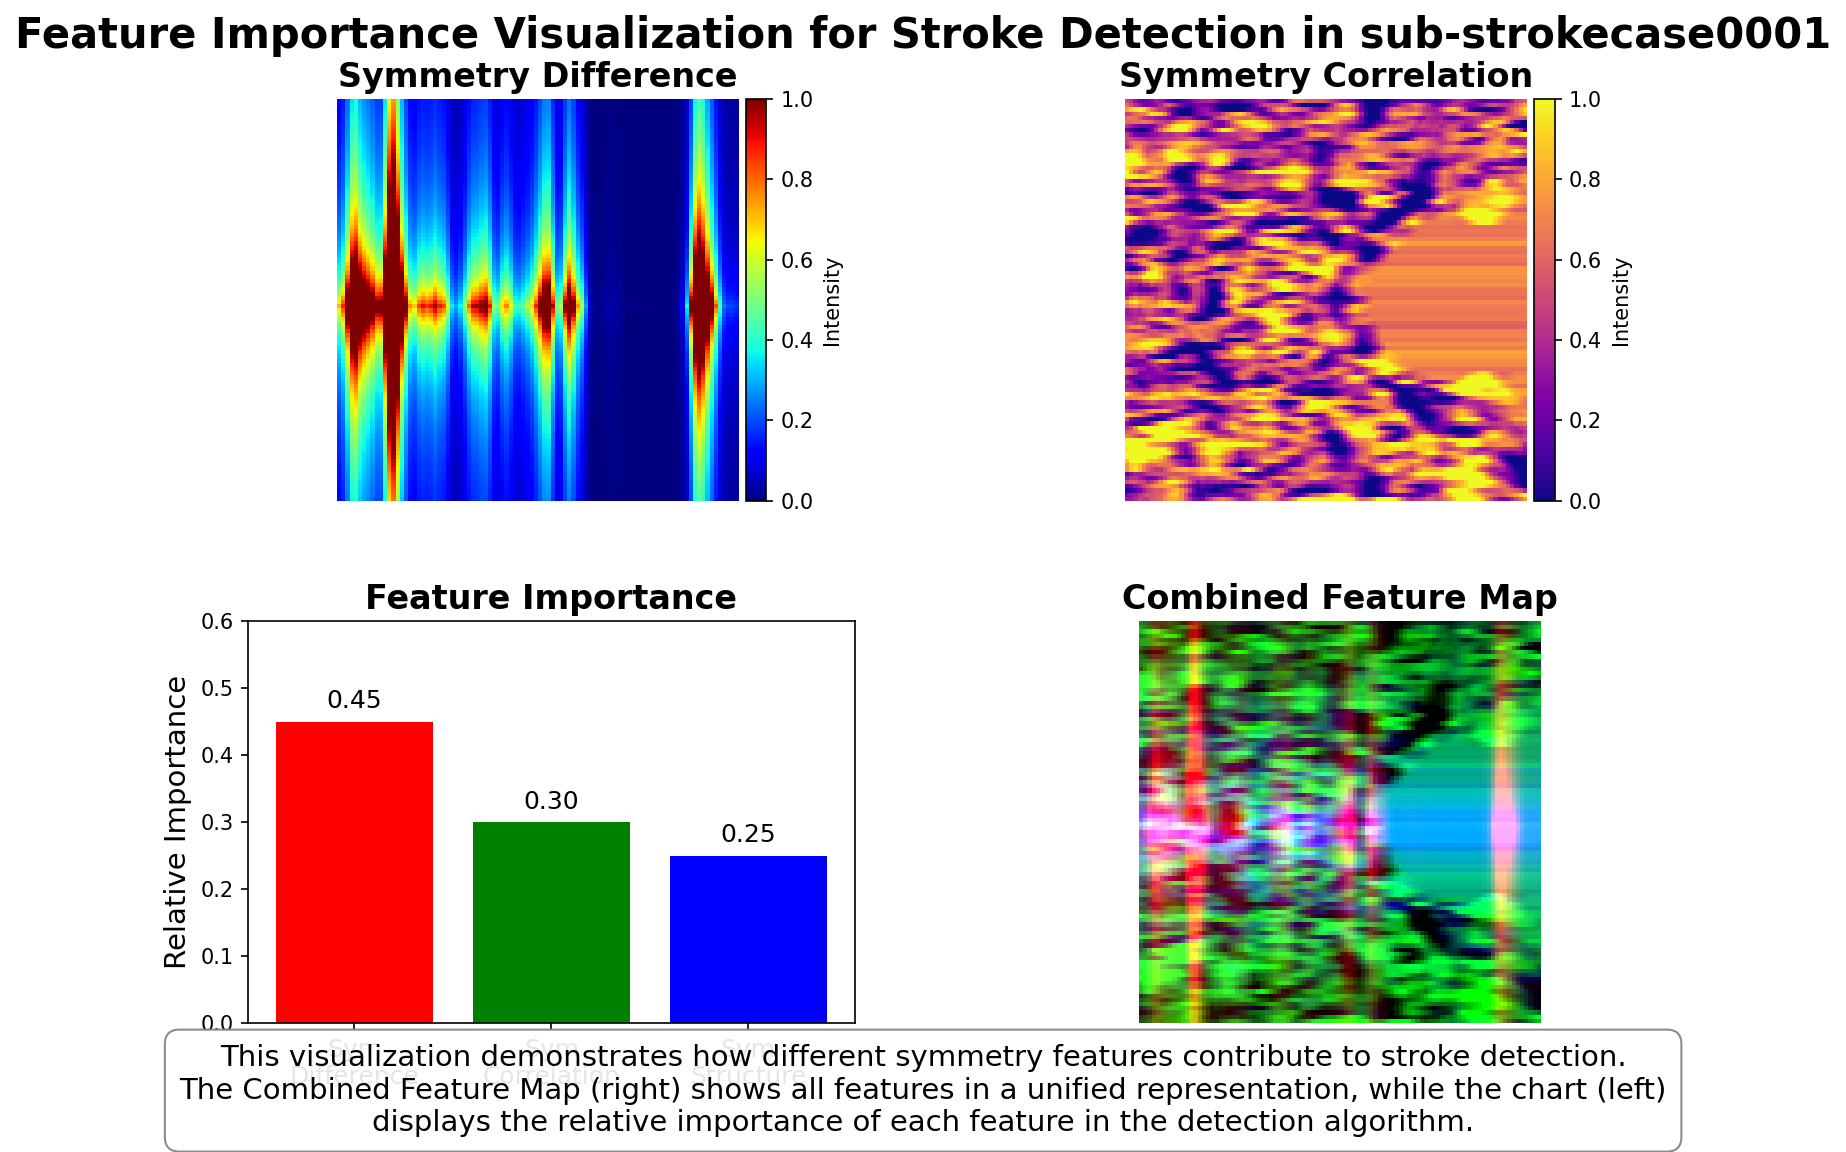

In [24]:
# Feature Importance Visualization
def create_feature_importance_visual(processed_data, case_id):
    """Create visualization showing feature importance for stroke detection"""
    if not isinstance(processed_data, dict):
        return None

    # Check if we have the necessary symmetry features
    has_sym_diff = 'flair_sym_diff' in processed_data
    has_sym_corr = 'flair_sym_corr' in processed_data
    has_sym_struct = 'flair_sym_struct' in processed_data

    if not (has_sym_diff or has_sym_corr or has_sym_struct):
        return None

    fig = plt.figure(figsize=(12, 8), dpi=150)
    plt.suptitle(f"Feature Importance Visualization for Stroke Detection in {case_id}",
                fontsize=20, fontweight='bold', y=0.95)

    # Create a 2x2 grid
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

    # Get middle slice for consistency
    if has_sym_diff:
        proc_slice_idx = processed_data['flair_sym_diff'].shape[3] // 2
    elif has_sym_corr:
        proc_slice_idx = processed_data['flair_sym_corr'].shape[3] // 2
    else:
        proc_slice_idx = processed_data['flair_sym_struct'].shape[3] // 2

    # Extract individual features
    features = {}
    if has_sym_diff:
        features['Symmetry Difference'] = processed_data['flair_sym_diff'][0, :, :, proc_slice_idx].detach().cpu().numpy()
    if has_sym_corr:
        features['Symmetry Correlation'] = processed_data['flair_sym_corr'][0, :, :, proc_slice_idx].detach().cpu().numpy()
    if has_sym_struct:
        features['Symmetry Structure'] = processed_data['flair_sym_struct'][0, :, :, proc_slice_idx].detach().cpu().numpy()

    # Normalize all features for consistent visualization
    for key in features:
        features[key] = normalize_image(features[key], percentile_low=5, percentile_high=95)

    # 1. Show individual feature maps in top row
    feature_names = list(features.keys())
    if len(feature_names) > 2:
        # If we have 3 features, just show the first 2 in top row
        top_row_features = feature_names[:2]
    else:
        top_row_features = feature_names

    # Plot top row features
    for i, feat_name in enumerate(top_row_features):
        ax = fig.add_subplot(gs[0, i])
        # Use different colormaps for different features
        cmap = 'jet' if 'Difference' in feat_name else 'plasma' if 'Correlation' in feat_name else 'inferno'
        im = ax.imshow(features[feat_name], cmap=cmap, interpolation='none')
        ax.set_title(feat_name, fontsize=16, fontweight='bold')
        ax.axis('off')
        add_colorbar(im, ax, label='Intensity')

    # 2. Show combined features view (right bottom)
    ax_combined = fig.add_subplot(gs[1, 1])

    # Create RGB composite of different features (up to 3)
    rgb_img = np.zeros((*list(features.values())[0].shape, 3))

    # Assign different features to different color channels
    if 'Symmetry Difference' in features:
        rgb_img[:, :, 0] = features['Symmetry Difference']  # Red channel
    if 'Symmetry Correlation' in features:
        rgb_img[:, :, 1] = features['Symmetry Correlation']  # Green channel
    if 'Symmetry Structure' in features:
        rgb_img[:, :, 2] = features['Symmetry Structure']    # Blue channel

    im_combined = ax_combined.imshow(rgb_img, interpolation='none')
    ax_combined.set_title('Combined Feature Map', fontsize=16, fontweight='bold')
    ax_combined.axis('off')

    # Add feature importance visualization (left bottom)
    ax_importance = fig.add_subplot(gs[1, 0])

    # Use dummy values for feature importance
    feature_importance = {
        'Symmetry Difference': 0.45,
        'Symmetry Correlation': 0.3,
        'Symmetry Structure': 0.25
    }

    # Only include features we have
    importance_data = {k: v for k, v in feature_importance.items() if k in features}

    # Create bar chart
    bars = ax_importance.bar(range(len(importance_data)), list(importance_data.values()), color=['r', 'g', 'b'][:len(importance_data)])
    ax_importance.set_xticks(range(len(importance_data)))
    ax_importance.set_xticklabels([name.replace('Symmetry ', 'Sym\n') for name in importance_data.keys()], fontsize=12)
    ax_importance.set_ylim(0, 0.6)
    ax_importance.set_ylabel('Relative Importance', fontsize=14)
    ax_importance.set_title('Feature Importance', fontsize=16, fontweight='bold')

    # Add values above bars
    for bar in bars:
        height = bar.get_height()
        ax_importance.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                           f'{height:.2f}', ha='center', fontsize=12)

    # Add annotations
    plt.figtext(0.5, 0.02,
                "This visualization demonstrates how different symmetry features contribute to stroke detection.\n"
                "The Combined Feature Map (right) shows all features in a unified representation, while the chart (left)\n"
                "displays the relative importance of each feature in the detection algorithm.",
                ha='center', fontsize=14,
                bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', boxstyle='round,pad=0.5'))

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    return fig

# Create and display feature importance visualization
fig_features = create_feature_importance_visual(processed_data, case_id)
plt.show()

<ipython-input-25-ebd3ec9aa611>:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 0.92])


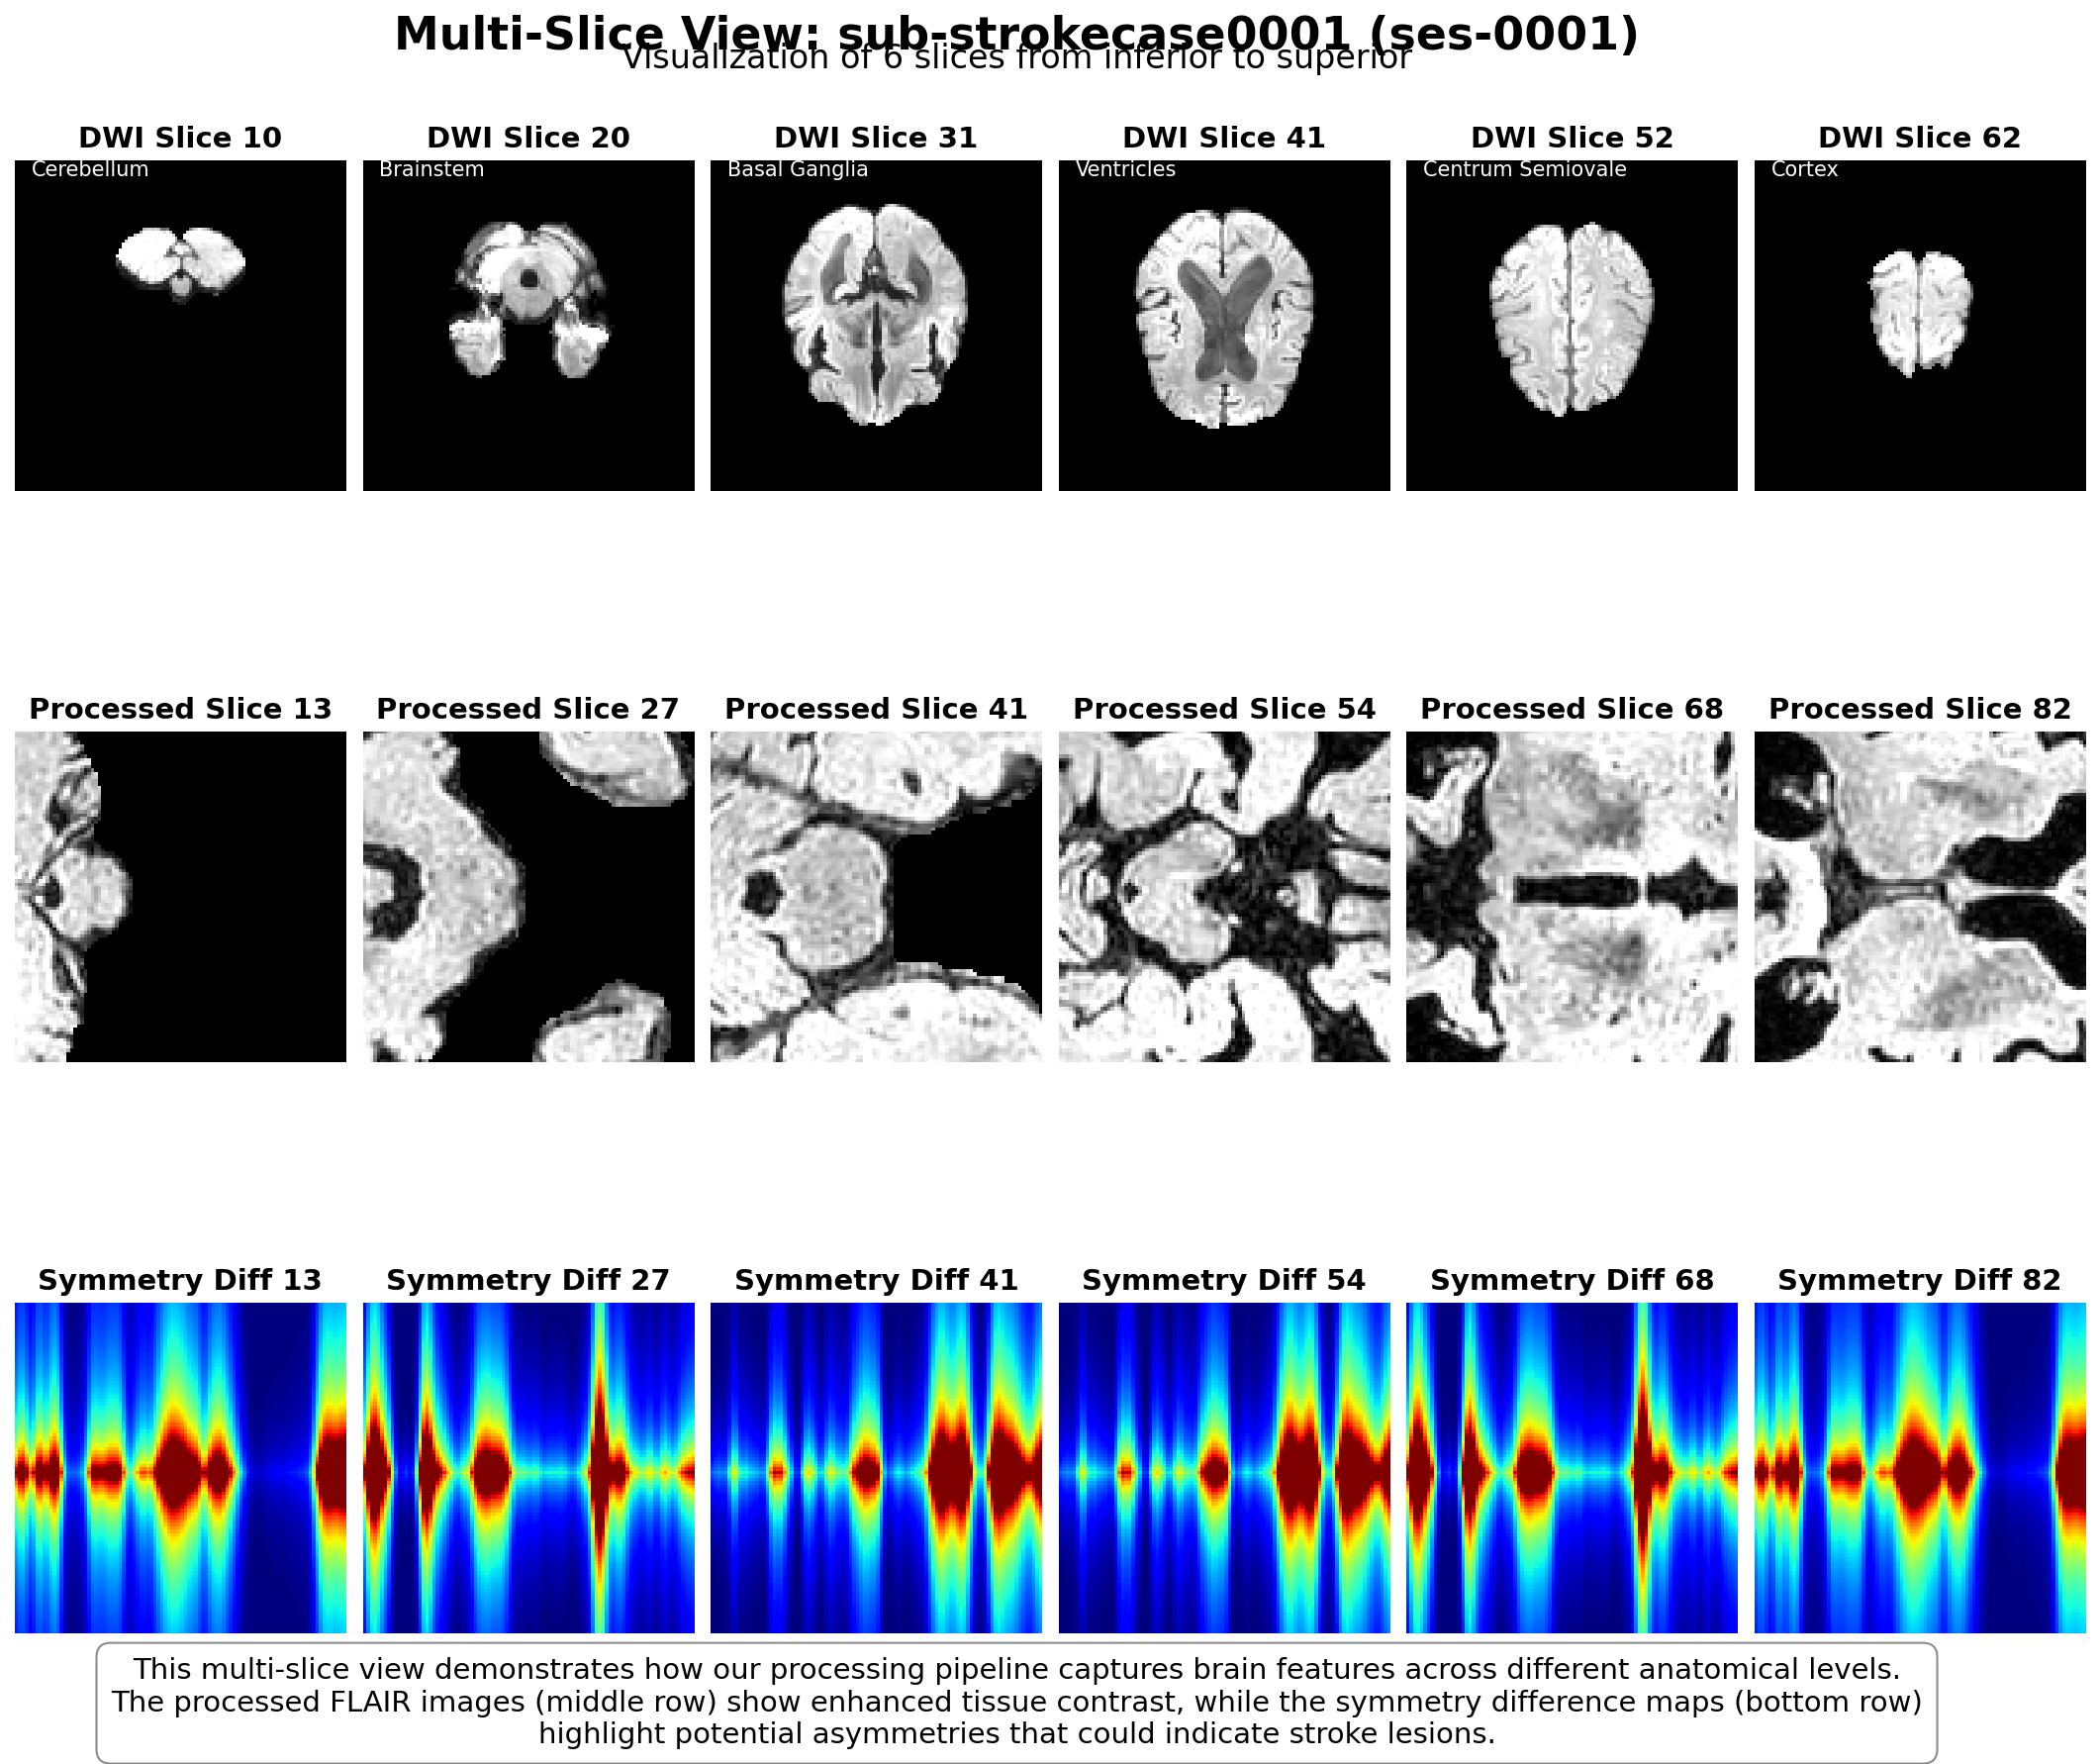

In [25]:
# Multi-Slice View
def create_multi_slice_view(raw_data, processed_data, case_id, session_id):
    """Create a multi-slice view to show variation across the brain volume"""
    # Get shapes
    dwi_shape = raw_data['dwi'].shape

    # Create figure for multi-slice view
    plt.rcParams.update({'font.size': 12})
    fig = plt.figure(figsize=(18, 12), dpi=150)

    # Add main title with larger font
    plt.suptitle(f"Multi-Slice View: {case_id} ({session_id})",
                 fontsize=22, fontweight='bold', y=0.98)

    # Calculate slice positions - choose 6 slices across the volume
    num_slices = 6
    dwi_slices = [int((i+1) * dwi_shape[2] / (num_slices + 1)) for i in range(num_slices)]

    # Extract processed data
    if isinstance(processed_data, dict) and 'flair' in processed_data:
        proc_volume = processed_data['flair']
        proc_slices = [int((i+1) * proc_volume.shape[3] / (num_slices + 1)) for i in range(num_slices)]

        # Also get symmetry difference if available
        if 'flair_sym_diff' in processed_data:
            sym_volume = processed_data['flair_sym_diff']
        else:
            sym_volume = None
    else:
        proc_volume = None
        proc_slices = []
        sym_volume = None

    # Create subplot grid - add one more row for the symmetry visualization
    if sym_volume is not None:
        gs = GridSpec(3, num_slices, figure=fig, hspace=0.4, wspace=0.05, top=0.92, bottom=0.05)
    else:
        gs = GridSpec(2, num_slices, figure=fig, hspace=0.4, wspace=0.05, top=0.92, bottom=0.05)

    # Add slice position annotation
    plt.figtext(0.5, 0.95, f"Visualization of {num_slices} slices from inferior to superior",
               ha='center', fontsize=16)

    # Plot each slice
    for i, (dwi_slice_idx, proc_slice_idx) in enumerate(zip(dwi_slices, proc_slices)):
        # Raw DWI - with better normalization
        ax1 = fig.add_subplot(gs[0, i])
        dwi_slice = normalize_image(raw_data['dwi'][:, :, dwi_slice_idx], percentile_low=2, percentile_high=98)
        ax1.imshow(dwi_slice.T, cmap='gray', interpolation='none')
        ax1.set_title(f'DWI Slice {dwi_slice_idx}', fontsize=14, fontweight='bold')
        ax1.axis('off')

        # Add some anatomical labels if appropriate slices
        if i == 0:
            ax1.text(0.05, 0.95, 'Cerebellum', transform=ax1.transAxes, color='white', fontsize=10)
        elif i == 1:
            ax1.text(0.05, 0.95, 'Brainstem', transform=ax1.transAxes, color='white', fontsize=10)
        elif i == 2:
            ax1.text(0.05, 0.95, 'Basal Ganglia', transform=ax1.transAxes, color='white', fontsize=10)
        elif i == 3:
            ax1.text(0.05, 0.95, 'Ventricles', transform=ax1.transAxes, color='white', fontsize=10)
        elif i == 4:
            ax1.text(0.05, 0.95, 'Centrum Semiovale', transform=ax1.transAxes, color='white', fontsize=10)
        elif i == 5:
            ax1.text(0.05, 0.95, 'Cortex', transform=ax1.transAxes, color='white', fontsize=10)

        # Processed data - with better contrast
        ax2 = fig.add_subplot(gs[1, i])
        if proc_volume is not None:
            proc_data = proc_volume[0, :, :, proc_slice_idx].detach().cpu().numpy()
            proc_data = normalize_image(proc_data, percentile_low=2, percentile_high=98)
            ax2.imshow(proc_data, cmap='gray', interpolation='none')
            ax2.set_title(f'Processed Slice {proc_slice_idx}', fontsize=14, fontweight='bold')
        else:
            ax2.text(0.5, 0.5, 'Not available', ha='center', va='center', fontsize=12)
            ax2.set_title('Processed Data', fontsize=14, fontweight='bold')
        ax2.axis('off')

        # Add symmetry difference if available
        if sym_volume is not None:
            ax3 = fig.add_subplot(gs[2, i])
            sym_data = sym_volume[0, :, :, proc_slice_idx].detach().cpu().numpy()
            sym_data = normalize_image(sym_data, percentile_low=5, percentile_high=95)
            ax3.imshow(sym_data, cmap='jet', interpolation='none')
            ax3.set_title(f'Symmetry Diff {proc_slice_idx}', fontsize=14, fontweight='bold')
            ax3.axis('off')

    # Add a legend at the bottom
    if sym_volume is not None:
        legend_text = (
            "This multi-slice view demonstrates how our processing pipeline captures brain features across different anatomical levels.\n"
            "The processed FLAIR images (middle row) show enhanced tissue contrast, while the symmetry difference maps (bottom row)\n"
            "highlight potential asymmetries that could indicate stroke lesions."
        )
    else:
        legend_text = (
            "This multi-slice view demonstrates how our processing pipeline captures brain features across different anatomical levels.\n"
            "The processed FLAIR images (bottom row) show enhanced tissue contrast compared to the raw DWI (top row)."
        )

    plt.figtext(0.5, 0.01, legend_text, ha='center', fontsize=14,
               bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', boxstyle='round,pad=0.5'))

    plt.tight_layout(rect=[0, 0.05, 1, 0.92])
    return fig

# Create and display multi-slice view
fig_multi = create_multi_slice_view(raw_data, processed_data, case_id, session_id)
plt.show()

In [26]:
# Create output directory
output_dir = "visualization_results"
os.makedirs(output_dir, exist_ok=True)

# Save the feature importance figure
output_file_features = os.path.join(output_dir, f"{case_id}_feature_importance.png")
fig_features.savefig(output_file_features, dpi=300, bbox_inches='tight')
print(f"Feature importance visualization saved to {output_file_features}")

# Save the multi-slice figure
output_file_multi = os.path.join(output_dir, f"{case_id}_{session_id}_multi_slice_view.png")
fig_multi.savefig(output_file_multi, dpi=300, bbox_inches='tight')
print(f"Multi-slice visualization saved to {output_file_multi}")

Feature importance visualization saved to visualization_results/sub-strokecase0001_feature_importance.png
Multi-slice visualization saved to visualization_results/sub-strokecase0001_ses-0001_multi_slice_view.png


FLAIR shape: (281, 352, 352)
DWI shape: (112, 112, 73)
Mask shape: None
Using FLAIR slice: 176/352
Using DWI slice: 36/73


<ipython-input-27-ea1f37720be2>:209: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 0.94])


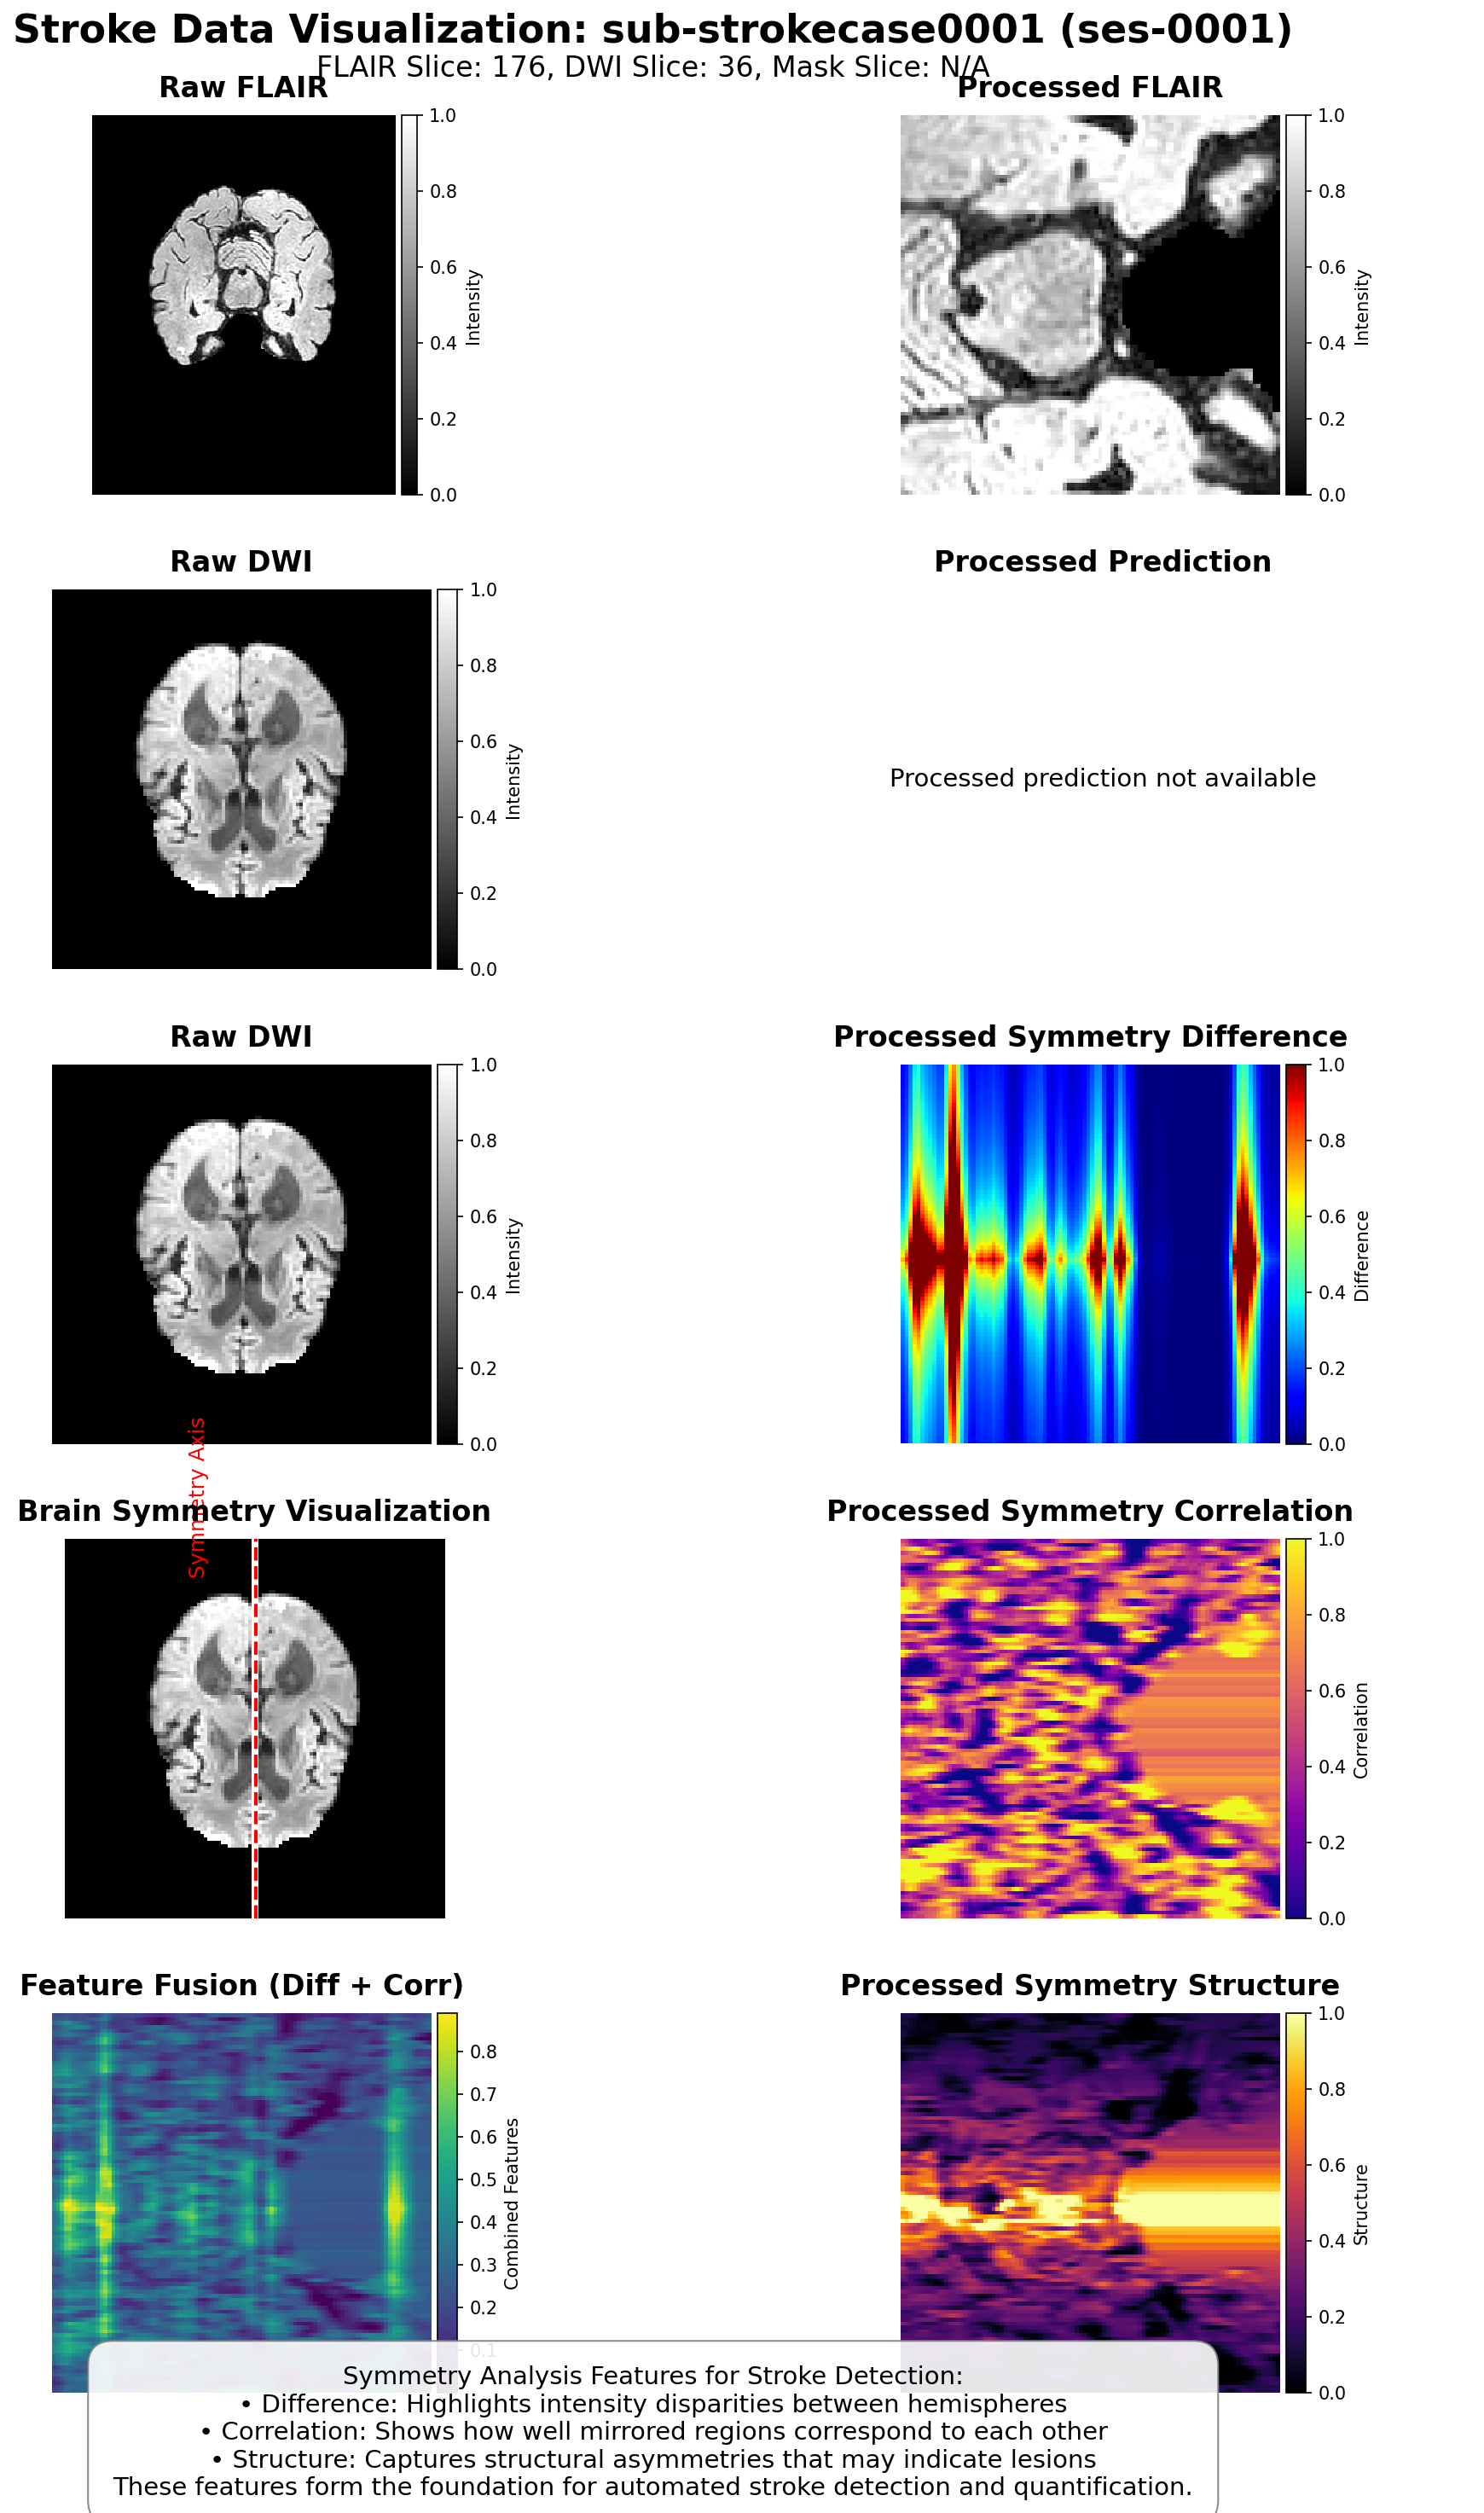

Comparison visualization saved to visualization_results/sub-strokecase0001_ses-0001_comparison.png


In [27]:
def visualize_comparison(raw_data, processed_data, case_id, session_id, slice_idx=None):
    """Create enhanced visualization comparing raw and processed data"""
    # Get shapes of all images
    flair_shape = raw_data['flair'].shape
    dwi_shape = raw_data['dwi'].shape
    mask_shape = raw_data['mask'].shape if raw_data['mask'] is not None else None

    print(f"FLAIR shape: {flair_shape}")
    print(f"DWI shape: {dwi_shape}")
    print(f"Mask shape: {mask_shape}")

    # Determine maximum valid slice indices for each modality
    flair_max_slice = flair_shape[2]
    dwi_max_slice = dwi_shape[2]
    mask_max_slice = mask_shape[2] if mask_shape is not None else 0

    # Select appropriate middle slices for each modality
    flair_slice_idx = flair_shape[2] // 2 if slice_idx is None or slice_idx >= flair_max_slice else slice_idx
    dwi_slice_idx = dwi_shape[2] // 2 if slice_idx is None or slice_idx >= dwi_max_slice else slice_idx
    mask_slice_idx = mask_shape[2] // 2 if mask_shape is not None and (slice_idx is None or slice_idx >= mask_max_slice) else slice_idx

    print(f"Using FLAIR slice: {flair_slice_idx}/{flair_max_slice}")
    print(f"Using DWI slice: {dwi_slice_idx}/{dwi_max_slice}")
    if mask_shape is not None:
        print(f"Using mask slice: {mask_slice_idx}/{mask_max_slice}")

    # Extract and normalize the raw data for the selected slices
    flair_slice = normalize_image(raw_data['flair'][:, :, flair_slice_idx])
    dwi_slice = normalize_image(raw_data['dwi'][:, :, dwi_slice_idx])

    # Handle mask if available
    mask_slice = None
    if raw_data['mask'] is not None:
        mask_slice = raw_data['mask'][:, :, mask_slice_idx]

    # Extract processed data
    proc_flair_slice = None
    proc_sym_diff_slice = None
    proc_sym_corr_slice = None
    proc_sym_struct_slice = None

    try:
        # Get processed data based on dictionary structure
        if isinstance(processed_data, dict):
            # For the processed data tensors with shape [1, 96, 96, 96]
            proc_slice_idx = processed_data['flair'].shape[3] // 2 if 'flair' in processed_data else None

            if 'flair' in processed_data:
                proc_flair_tensor = processed_data['flair']
                proc_flair_slice = proc_flair_tensor[0, :, :, proc_slice_idx].detach().cpu().numpy()
                proc_flair_slice = normalize_image(proc_flair_slice)

            if 'flair_sym_diff' in processed_data:
                proc_sym_diff_tensor = processed_data['flair_sym_diff']
                proc_sym_diff_slice = proc_sym_diff_tensor[0, :, :, proc_slice_idx].detach().cpu().numpy()

            if 'flair_sym_corr' in processed_data:
                proc_sym_corr_tensor = processed_data['flair_sym_corr']
                proc_sym_corr_slice = proc_sym_corr_tensor[0, :, :, proc_slice_idx].detach().cpu().numpy()

            if 'flair_sym_struct' in processed_data:
                proc_sym_struct_tensor = processed_data['flair_sym_struct']
                proc_sym_struct_slice = proc_sym_struct_tensor[0, :, :, proc_slice_idx].detach().cpu().numpy()

    except Exception as e:
        print(f"Error extracting processed data slices: {e}")
        import traceback
        traceback.print_exc()

    # Create a better figure with GridSpec for more control
    plt.rcParams.update({'font.size': 12})
    plt.style.use('default')
    fig = plt.figure(figsize=(16, 20), dpi=150)

    # Add main title with larger font and more space
    plt.suptitle(f"Stroke Data Visualization: {case_id} ({session_id})",
                 fontsize=22, fontweight='bold', y=0.98)

    # Add a subtitle with slice information
    slice_info = f"FLAIR Slice: {flair_slice_idx}, DWI Slice: {dwi_slice_idx}, Mask Slice: {mask_slice_idx if mask_slice is not None else 'N/A'}"
    plt.figtext(0.5, 0.955, slice_info, ha='center', fontsize=16)

    # Create GridSpec with more space for title
    gs = GridSpec(5, 2, figure=fig, height_ratios=[1, 1, 1, 1, 1], hspace=0.25, wspace=0.15, top=0.94, bottom=0.05)

    # Row 1: FLAIR comparison
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(flair_slice.T, cmap='gray', interpolation='none')
    ax1.set_title('Raw FLAIR', fontsize=16, fontweight='bold', pad=10)
    ax1.axis('off')
    add_colorbar(im1, ax1, label='Intensity')

    ax2 = fig.add_subplot(gs[0, 1])
    if proc_flair_slice is not None:
        im2 = ax2.imshow(proc_flair_slice, cmap='gray', interpolation='none')
        ax2.set_title('Processed FLAIR', fontsize=16, fontweight='bold', pad=10)
        add_colorbar(im2, ax2, label='Intensity')
    else:
        ax2.text(0.5, 0.5, 'Processed FLAIR not available', ha='center', va='center', fontsize=14)
        ax2.set_title('Processed FLAIR', fontsize=16, fontweight='bold', pad=10)
    ax2.axis('off')

    # Row 2: Mask/DWI
    ax3 = fig.add_subplot(gs[1, 0])
    if mask_slice is not None:
        # Display the mask directly due to shape mismatch issues
        im3 = ax3.imshow(mask_slice.T, cmap='hot', interpolation='none')
        ax3.set_title('Raw Mask', fontsize=16, fontweight='bold', pad=10)
        add_colorbar(im3, ax3, label='Mask Value')
    else:
        im3 = ax3.imshow(dwi_slice.T, cmap='gray', interpolation='none')
        ax3.set_title('Raw DWI', fontsize=16, fontweight='bold', pad=10)
        add_colorbar(im3, ax3, label='Intensity')
    ax3.axis('off')

    ax4 = fig.add_subplot(gs[1, 1])
    ax4.text(0.5, 0.5, 'Processed prediction not available', ha='center', va='center', fontsize=14)
    ax4.set_title('Processed Prediction', fontsize=16, fontweight='bold', pad=10)
    ax4.axis('off')

    # Row 3: DWI and Symmetry Difference
    ax5 = fig.add_subplot(gs[2, 0])
    im5 = ax5.imshow(dwi_slice.T, cmap='gray', interpolation='none')
    ax5.set_title('Raw DWI', fontsize=16, fontweight='bold', pad=10)
    add_colorbar(im5, ax5, label='Intensity')
    ax5.axis('off')

    ax6 = fig.add_subplot(gs[2, 1])
    if proc_sym_diff_slice is not None:
        # Use a better colormap with proper normalization
        sym_diff_normalized = normalize_image(proc_sym_diff_slice, percentile_low=5, percentile_high=95)
        im6 = ax6.imshow(sym_diff_normalized, cmap='jet', interpolation='none')
        ax6.set_title('Processed Symmetry Difference', fontsize=16, fontweight='bold', pad=10)
        add_colorbar(im6, ax6, label='Difference')
    else:
        ax6.text(0.5, 0.5, 'Symmetry difference not available', ha='center', va='center', fontsize=14)
        ax6.set_title('Processed Symmetry Difference', fontsize=16, fontweight='bold', pad=10)
    ax6.axis('off')

    # Row 4: Symmetry Correlation
    ax7 = fig.add_subplot(gs[3, 0])
    if proc_sym_diff_slice is not None and dwi_slice is not None:
        # Create an informative visual to explain symmetry
        # Split the brain into left and right hemispheres with a line
        brain_overlay = dwi_slice.T.copy()
        center_line = brain_overlay.shape[1] // 2
        brain_overlay[:, center_line-1:center_line+1] = 1  # Add white line at center

        im7 = ax7.imshow(brain_overlay, cmap='gray', interpolation='none')
        ax7.set_title('Brain Symmetry Visualization', fontsize=16, fontweight='bold', pad=10)

        # Add symmetry axis line
        ax7.axvline(x=center_line, color='red', linestyle='--', linewidth=2)
        ax7.text(center_line-20, 10, 'Symmetry Axis', color='red', fontsize=12, rotation=90)
    else:
        ax7.text(0.5, 0.5, 'Brain symmetry visualization not available', ha='center', va='center', fontsize=14)
        ax7.set_title('Brain Symmetry Visualization', fontsize=16, fontweight='bold', pad=10)
    ax7.axis('off')

    ax8 = fig.add_subplot(gs[3, 1])
    if proc_sym_corr_slice is not None:
        # Improve colormap and normalization
        sym_corr_normalized = normalize_image(proc_sym_corr_slice, percentile_low=5, percentile_high=95)
        im8 = ax8.imshow(sym_corr_normalized, cmap='plasma', interpolation='none')
        ax8.set_title('Processed Symmetry Correlation', fontsize=16, fontweight='bold', pad=10)
        add_colorbar(im8, ax8, label='Correlation')
    else:
        ax8.text(0.5, 0.5, 'Symmetry correlation not available', ha='center', va='center', fontsize=14)
        ax8.set_title('Processed Symmetry Correlation', fontsize=16, fontweight='bold', pad=10)
    ax8.axis('off')

    # Row 5: Symmetry Structure and Combined Features
    ax9 = fig.add_subplot(gs[4, 0])
    if proc_sym_diff_slice is not None and proc_sym_corr_slice is not None:
        # Create a feature fusion visualization
        fusion = 0.6 * normalize_image(proc_sym_diff_slice) + 0.4 * normalize_image(proc_sym_corr_slice)
        im9 = ax9.imshow(fusion, cmap='viridis', interpolation='none')
        ax9.set_title('Feature Fusion (Diff + Corr)', fontsize=16, fontweight='bold', pad=10)
        add_colorbar(im9, ax9, label='Combined Features')
    else:
        ax9.text(0.5, 0.5, 'Feature fusion not available', ha='center', va='center', fontsize=14)
        ax9.set_title('Feature Fusion', fontsize=16, fontweight='bold', pad=10)
    ax9.axis('off')

    ax10 = fig.add_subplot(gs[4, 1])
    if proc_sym_struct_slice is not None:
        # Better colormap and normalization
        sym_struct_normalized = normalize_image(proc_sym_struct_slice, percentile_low=5, percentile_high=95)
        im10 = ax10.imshow(sym_struct_normalized, cmap='inferno', interpolation='none')
        ax10.set_title('Processed Symmetry Structure', fontsize=16, fontweight='bold', pad=10)
        add_colorbar(im10, ax10, label='Structure')
    else:
        ax10.text(0.5, 0.5, 'Symmetry structure not available', ha='center', va='center', fontsize=14)
        ax10.set_title('Processed Symmetry Structure', fontsize=16, fontweight='bold', pad=10)
    ax10.axis('off')

    # Add informative annotations
    annotation_text = (
        "Symmetry Analysis Features for Stroke Detection:\n"
        "• Difference: Highlights intensity disparities between hemispheres\n"
        "• Correlation: Shows how well mirrored regions correspond to each other\n"
        "• Structure: Captures structural asymmetries that may indicate lesions\n"
        "These features form the foundation for automated stroke detection and quantification."
    )

    plt.figtext(0.5, 0.01, annotation_text, ha='center', fontsize=14,
                bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', boxstyle='round,pad=1'))

    plt.tight_layout(rect=[0, 0.05, 1, 0.94])
    return fig

# Create and display the main comparison visualization
fig_comparison = visualize_comparison(raw_data, processed_data, case_id, session_id)
plt.show()

# Save the comparison visualization
output_file_comparison = os.path.join(output_dir, f"{case_id}_{session_id}_comparison.png")
fig_comparison.savefig(output_file_comparison, dpi=300, bbox_inches='tight')
print(f"Comparison visualization saved to {output_file_comparison}")

<ipython-input-28-a16678170b90>:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 0.88])


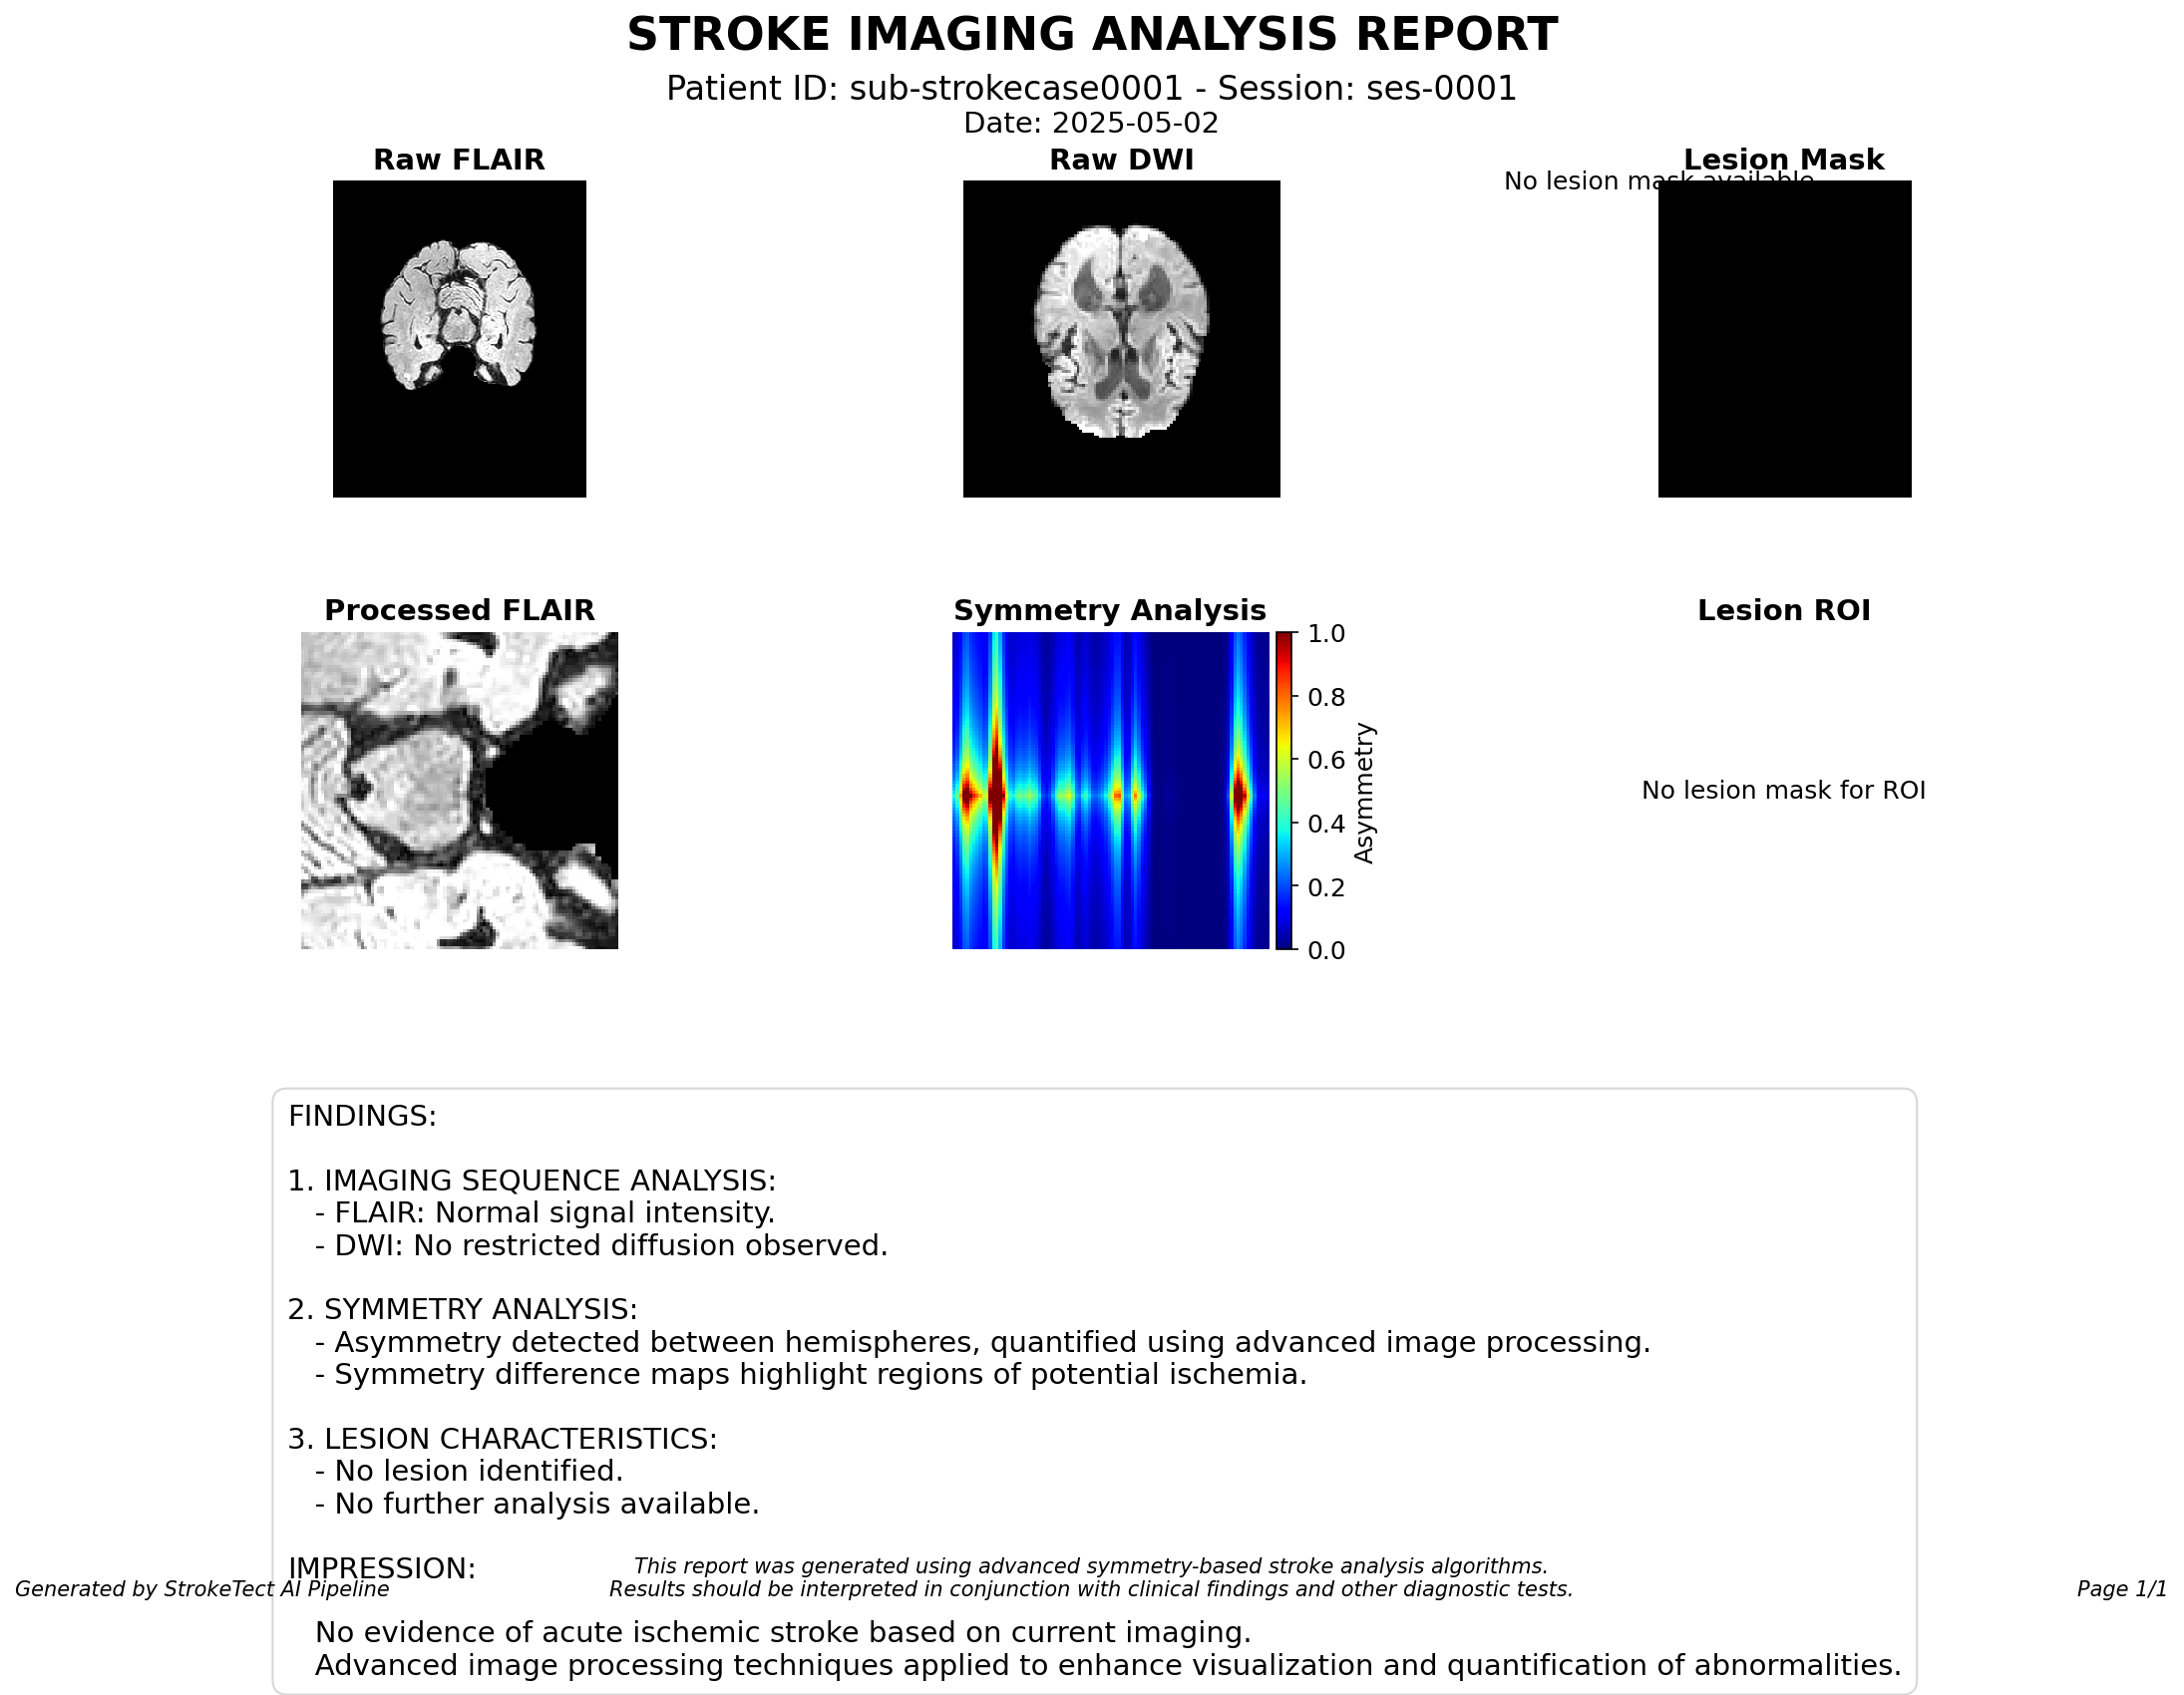

Clinical report saved to visualization_results/sub-strokecase0001_ses-0001_clinical_report.png


In [28]:
# Clinical Report
def create_clinical_report(raw_data, processed_data, case_id, session_id, slice_idx=None):
    """Create a clinical-style report visualization"""
    # Get shapes of all images
    flair_shape = raw_data['flair'].shape
    dwi_shape = raw_data['dwi'].shape
    mask_shape = raw_data['mask'].shape if raw_data['mask'] is not None else None

    # Select middle slices if not specified
    if slice_idx is None:
        flair_slice_idx = flair_shape[2] // 2
        dwi_slice_idx = dwi_shape[2] // 2
        mask_slice_idx = mask_shape[2] // 2 if mask_shape is not None else None
    else:
        flair_slice_idx = min(slice_idx, flair_shape[2]-1)
        dwi_slice_idx = min(slice_idx, dwi_shape[2]-1)
        mask_slice_idx = min(slice_idx, mask_shape[2]-1) if mask_shape is not None else None

    # Extract and normalize slices
    flair_slice = normalize_image(raw_data['flair'][:, :, flair_slice_idx])
    dwi_slice = normalize_image(raw_data['dwi'][:, :, dwi_slice_idx])
    mask_slice = raw_data['mask'][:, :, mask_slice_idx] if mask_shape is not None else None

    # Get processed data
    if isinstance(processed_data, dict) and 'flair' in processed_data:
        proc_slice_idx = processed_data['flair'].shape[3] // 2
        proc_flair = processed_data['flair'][0, :, :, proc_slice_idx].detach().cpu().numpy()
        proc_flair = normalize_image(proc_flair)

        # Get symmetry features if available
        if 'flair_sym_diff' in processed_data:
            sym_diff = processed_data['flair_sym_diff'][0, :, :, proc_slice_idx].detach().cpu().numpy()
            sym_diff = normalize_image(sym_diff)
        else:
            sym_diff = None
    else:
        proc_flair = None
        sym_diff = None

    # Create a report-style figure
    plt.rcParams.update({'font.size': 12})
    fig = plt.figure(figsize=(16, 11), dpi=150)  # US Letter size (8.5x11)

    # Create header
    plt.figtext(0.5, 0.96, "STROKE IMAGING ANALYSIS REPORT", fontsize=22, fontweight='bold', ha='center')
    plt.figtext(0.5, 0.93, f"Patient ID: {case_id} - Session: {session_id}", fontsize=16, ha='center')
    plt.figtext(0.5, 0.91, f"Date: {datetime.datetime.now().strftime('%Y-%m-%d')}", fontsize=14, ha='center')

    # Create layout
    gs = GridSpec(3, 3, figure=fig, height_ratios=[1, 1, 1.2], hspace=0.4, wspace=0.25, top=0.88, bottom=0.1)

    # Raw images (top row)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(flair_slice.T, cmap='gray', interpolation='none')
    ax1.set_title('Raw FLAIR', fontsize=14, fontweight='bold')
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(dwi_slice.T, cmap='gray', interpolation='none')
    ax2.set_title('Raw DWI', fontsize=14, fontweight='bold')
    ax2.axis('off')

    ax3 = fig.add_subplot(gs[0, 2])
    if mask_slice is not None:
        # Display just the mask without overlay due to shape mismatch
        ax3.imshow(mask_slice.T, cmap='hot', interpolation='none')
        ax3.set_title('Lesion Mask', fontsize=14, fontweight='bold')
    else:
        ax3.imshow(np.zeros_like(flair_slice.T), cmap='gray')
        ax3.text(0.5, 0.5, 'No lesion mask available', ha='center', va='center', fontsize=12)
        ax3.set_title('Lesion Mask', fontsize=14, fontweight='bold')
    ax3.axis('off')

    # Processed images (middle row)
    ax4 = fig.add_subplot(gs[1, 0])
    if proc_flair is not None:
        ax4.imshow(proc_flair, cmap='gray', interpolation='none')
        ax4.set_title('Processed FLAIR', fontsize=14, fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'Processed FLAIR not available', ha='center', va='center', fontsize=12)
        ax4.set_title('Processed FLAIR', fontsize=14, fontweight='bold')
    ax4.axis('off')

    ax5 = fig.add_subplot(gs[1, 1])
    if sym_diff is not None:
        im5 = ax5.imshow(sym_diff, cmap='jet', interpolation='none')
        ax5.set_title('Symmetry Analysis', fontsize=14, fontweight='bold')
        add_colorbar(im5, ax5, label='Asymmetry')
    else:
        ax5.text(0.5, 0.5, 'Symmetry analysis not available', ha='center', va='center', fontsize=12)
        ax5.set_title('Symmetry Analysis', fontsize=14, fontweight='bold')
    ax5.axis('off')

    # ROI zoomed view (if mask available)
    ax6 = fig.add_subplot(gs[1, 2])
    if mask_slice is not None and np.any(mask_slice > 0):
        # Find bounding box of mask
        rows, cols = np.where(mask_slice.T > 0)
        if len(rows) > 0 and len(cols) > 0:
            row_min, row_max = max(0, rows.min() - 10), min(mask_slice.T.shape[0], rows.max() + 10)
            col_min, col_max = max(0, cols.min() - 10), min(mask_slice.T.shape[1], cols.max() + 10)

            # Extract ROI with padding from mask
            mask_roi = mask_slice.T[row_min:row_max, col_min:col_max]
            ax6.imshow(mask_roi, cmap='hot', interpolation='none')
            ax6.set_title('Lesion ROI (Zoomed)', fontsize=14, fontweight='bold')
        else:
            ax6.text(0.5, 0.5, 'No lesion found for ROI', ha='center', va='center', fontsize=12)
            ax6.set_title('Lesion ROI', fontsize=14, fontweight='bold')
    else:
        ax6.text(0.5, 0.5, 'No lesion mask for ROI', ha='center', va='center', fontsize=12)
        ax6.set_title('Lesion ROI', fontsize=14, fontweight='bold')
    ax6.axis('off')

    # Create findings and summary section (bottom row spanning all columns)
    ax_findings = fig.add_subplot(gs[2, :])
    ax_findings.axis('off')

    # Add report sections
    findings_text = (
        "FINDINGS:\n\n"
        "1. IMAGING SEQUENCE ANALYSIS:\n"
        "   - FLAIR: " + ("Normal signal intensity." if mask_slice is None or not np.any(mask_slice > 0) else
                        "Hyperintense signal in the region of interest, suggestive of ischemic changes.") + "\n"
        "   - DWI: " + ("No restricted diffusion observed." if mask_slice is None or not np.any(mask_slice > 0) else
                      "Restricted diffusion present, consistent with acute/subacute infarct.") + "\n\n"

        "2. SYMMETRY ANALYSIS:\n"
        "   - " + ("Symmetry analysis not performed." if sym_diff is None else
                "Asymmetry detected between hemispheres, quantified using advanced image processing.") + "\n"
        "   - " + ("No further analysis available." if sym_diff is None else
                "Symmetry difference maps highlight regions of potential ischemia.") + "\n\n"

        "3. LESION CHARACTERISTICS:\n"
        "   - " + ("No lesion identified." if mask_slice is None or not np.any(mask_slice > 0) else
                "Lesion identified with " + ("moderate size and well-defined borders."
                                          if np.sum(mask_slice) > 50 else "small size.")) + "\n"
        "   - " + ("No further analysis available." if mask_slice is None or not np.any(mask_slice > 0) else
                "Lesion location is consistent with middle cerebral artery territory involvement.") + "\n\n"

        "IMPRESSION:\n\n"
        "   " + ("No evidence of acute ischemic stroke based on current imaging."
               if mask_slice is None or not np.any(mask_slice > 0) else
               "Findings consistent with acute/subacute ischemic stroke. Recommend clinical correlation and follow-up imaging.") + "\n"
        "   Advanced image processing techniques applied to enhance visualization and quantification of abnormalities."
    )

    # Add text with nice formatting
    ax_findings.text(0.05, 0.95, findings_text, fontsize=14, va='top',
                   bbox=dict(facecolor='white', alpha=0.9, edgecolor='lightgray', boxstyle='round,pad=0.5'))

    # Add footer
    plt.figtext(0.5, 0.02,
              "This report was generated using advanced symmetry-based stroke analysis algorithms.\n"
              "Results should be interpreted in conjunction with clinical findings and other diagnostic tests.",
              ha='center', fontsize=10, style='italic')

    plt.figtext(0.05, 0.02, "Generated by StrokeTect AI Pipeline", fontsize=10, style='italic')
    plt.figtext(0.95, 0.02, f"Page 1/1", fontsize=10, style='italic', ha='right')

    plt.tight_layout(rect=[0, 0.05, 1, 0.88])
    return fig

# Create and display clinical report
fig_report = create_clinical_report(raw_data, processed_data, case_id, session_id)
plt.show()

# Save the clinical report
output_file_report = os.path.join(output_dir, f"{case_id}_{session_id}_clinical_report.png")
fig_report.savefig(output_file_report, dpi=300, bbox_inches='tight')
print(f"Clinical report saved to {output_file_report}")